# Xgboost model training

In [6]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight
import os

In [7]:
#Loading data

#Defining BASE_PATH
BASE_PATH = os.getenv("/Users/carlos/Desktop/CURSOS/Anyone AI/Credit-Risk-App/dataset/", "/Users/carlos/Desktop/CURSOS/Anyone AI/Credit-Risk-App/dataset/")

train_file_path = os.path.join(BASE_PATH, "X_train_data.csv")
y_train_file_path = os.path.join(BASE_PATH, "y_train_data.csv")
val_file_path = os.path.join(BASE_PATH, "X_val_data.csv")
y_val_path = os.path.join(BASE_PATH, "y_val_data.csv")

train_df = pd.read_csv(train_file_path)

y_train_df = pd.read_csv(y_train_file_path)
y_train = y_train_df['TARGET_LABEL_BAD']
y_train = y_train.to_numpy()

val_df = pd.read_csv(val_file_path)

y_valid_df = pd.read_csv(y_val_path)
y_valid = y_valid_df['TARGET_LABEL_BAD']
y_valid = y_valid.to_numpy()


In [55]:
print(train_df.columns.to_list())

['APPLICATION_SUBMISSION_TYPE', 'SEX', 'CITY_OF_BIRTH', 'RESIDENCIAL_CITY', 'RESIDENCIAL_BOROUGH', 'FLAG_RESIDENCIAL_PHONE', 'RESIDENCIAL_PHONE_AREA_CODE', 'FLAG_EMAIL', 'PERSONAL_MONTHLY_INCOME', 'OTHER_INCOMES', 'FLAG_VISA', 'FLAG_MASTERCARD', 'FLAG_DINERS', 'FLAG_AMERICAN_EXPRESS', 'FLAG_OTHER_CARDS', 'PERSONAL_ASSETS_VALUE', 'QUANT_CARS', 'COMPANY', 'FLAG_PROFESSIONAL_PHONE', 'MONTHS_IN_THE_JOB', 'RESIDENCIAL_ZIP_3', 'PROFESSIONAL_ZIP_3', 'STATE_OF_BIRTH_AC', 'STATE_OF_BIRTH_AL', 'STATE_OF_BIRTH_AM', 'STATE_OF_BIRTH_AP', 'STATE_OF_BIRTH_BA', 'STATE_OF_BIRTH_CE', 'STATE_OF_BIRTH_DF', 'STATE_OF_BIRTH_ES', 'STATE_OF_BIRTH_GO', 'STATE_OF_BIRTH_MA', 'STATE_OF_BIRTH_MG', 'STATE_OF_BIRTH_MS', 'STATE_OF_BIRTH_MT', 'STATE_OF_BIRTH_PA', 'STATE_OF_BIRTH_PB', 'STATE_OF_BIRTH_PE', 'STATE_OF_BIRTH_PI', 'STATE_OF_BIRTH_PR', 'STATE_OF_BIRTH_RJ', 'STATE_OF_BIRTH_RN', 'STATE_OF_BIRTH_RO', 'STATE_OF_BIRTH_RR', 'STATE_OF_BIRTH_RS', 'STATE_OF_BIRTH_SC', 'STATE_OF_BIRTH_SE', 'STATE_OF_BIRTH_SP', 'STATE_

In [37]:
# Definimos una función para evaluar y mostrar las métricas
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    # Predicciones en entrenamiento y validación
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Probabilidades para ROC-AUC
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_val_proba = model.predict_proba(X_val)[:, 1]
        
    # Métricas de validación
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred)
    val_recall = recall_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    val_roc_auc = roc_auc_score(y_val, y_val_proba)
    val_cm = confusion_matrix(y_val, y_val_pred)
    
    # Imprimir las métricas 
    print("\nMétricas de validación:")
    print(f"Accuracy: {val_accuracy:.4f}")
    print(f"Precision: {val_precision:.4f}")
    print(f"Recall: {val_recall:.4f}")
    print(f"F1 Score: {val_f1:.4f}")
    print(f"ROC-AUC: {val_roc_auc:.4f}")
    
    print("\nMatriz de confusión (validación):")
    print(val_cm)
    
    # Visualizar la matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Clase 0', 'Clase 1'],
                yticklabels=['Clase 0', 'Clase 1'])
    plt.xlabel('Predicción')
    plt.ylabel('Valor real')
    plt.title(f'Matriz de confusión - {model_name}')
    plt.tight_layout()
    plt.show()
    
    # Devolver las métricas de validación para comparación
    return {
        'model': model_name,
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1': val_f1,
        'roc_auc': val_roc_auc
    }


Métricas de validación:
Accuracy: 0.5839
Precision: 0.3408
Recall: 0.6014
F1 Score: 0.4350
ROC-AUC: 0.6240

Matriz de confusión (validación):
[[4237 3099]
 [1062 1602]]


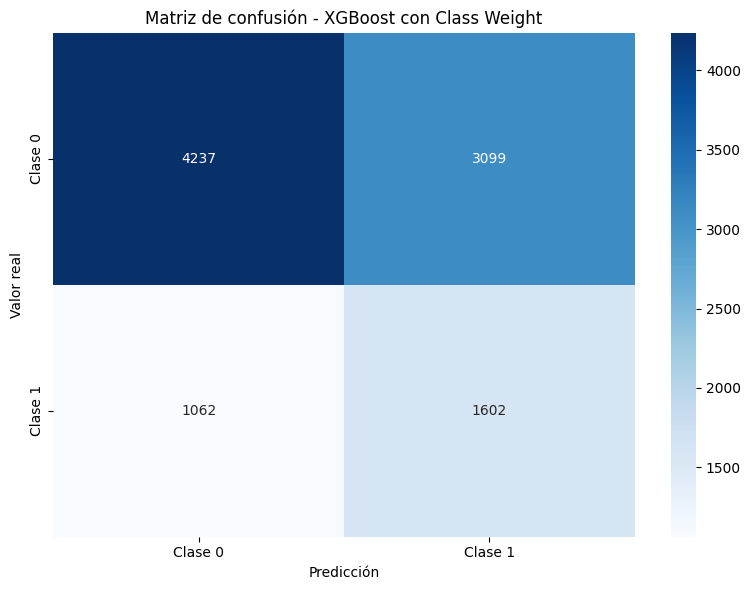

In [38]:
# =================================================================
# Estrategia 1: XGBoost con scale_pos_weight (Class Weight)
# =================================================================

# Calcular el ratio para scale_pos_weight
scale_pos_weight_ratio = np.sum(y_train == 0) / np.sum(y_train == 1)

# Entrenar el modelo con class weight balanceado
model_weight = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight_ratio,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)
model_weight.fit(train_df, y_train)

# Evaluar el modelo con class weight
results_weight = evaluate_model(model_weight, train_df, y_train, val_df, y_valid, "XGBoost con Class Weight")


Métricas de validación:
Accuracy: 0.7283
Precision: 0.4148
Recall: 0.0484
F1 Score: 0.0867
ROC-AUC: 0.6044

Matriz de confusión (validación):
[[7154  182]
 [2535  129]]


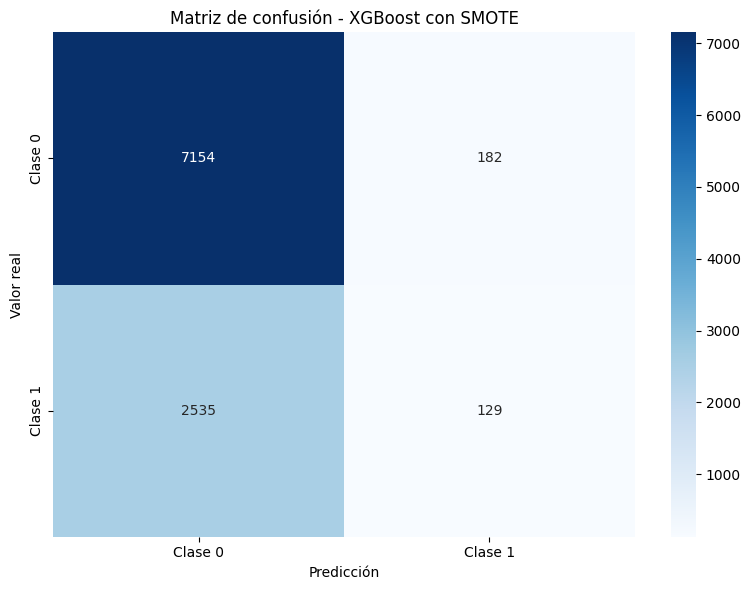

In [39]:
# =================================================================
# Estrategia 2: XGBoost con SMOTE
# =================================================================

# Aplicar SMOTE para sobremuestrear la clase minoritaria
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(train_df, y_train)

# Entrenar el modelo con datos balanceados usando SMOTE
model_smote = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)
model_smote.fit(X_train_smote, y_train_smote)

# Evaluar el modelo con SMOTE
results_smote = evaluate_model(model_smote, X_train_smote, y_train_smote, val_df, y_valid, "XGBoost con SMOTE")


Métricas de validación:
Accuracy: 0.5743
Precision: 0.3359
Recall: 0.6119
F1 Score: 0.4337
ROC-AUC: 0.6202

Matriz de confusión (validación):
[[4113 3223]
 [1034 1630]]


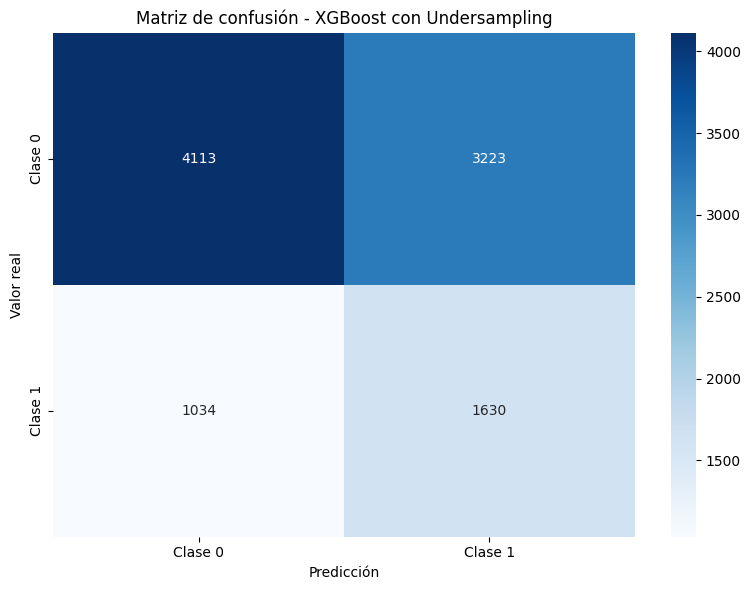

In [40]:
# =================================================================
# Estrategia 3: XGBoost con Undersampling
# =================================================================

# Aplicar undersampling para reducir la clase mayoritaria
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(train_df, y_train)

# Entrenar el modelo con datos balanceados usando undersampling
model_under = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)
model_under.fit(X_train_under, y_train_under)

# Evaluar el modelo con undersampling
results_under = evaluate_model(model_under, X_train_under, y_train_under, val_df, y_valid, "XGBoost con Undersampling")


===== Comparación de estrategias =====
                           accuracy  precision    recall        f1   roc_auc
model                                                                       
XGBoost con Class Weight     0.5839   0.340779  0.601351  0.435031  0.623951
XGBoost con SMOTE            0.7283   0.414791  0.048423  0.086723  0.604438
XGBoost con Undersampling    0.5743   0.335875  0.611862  0.433684  0.620218


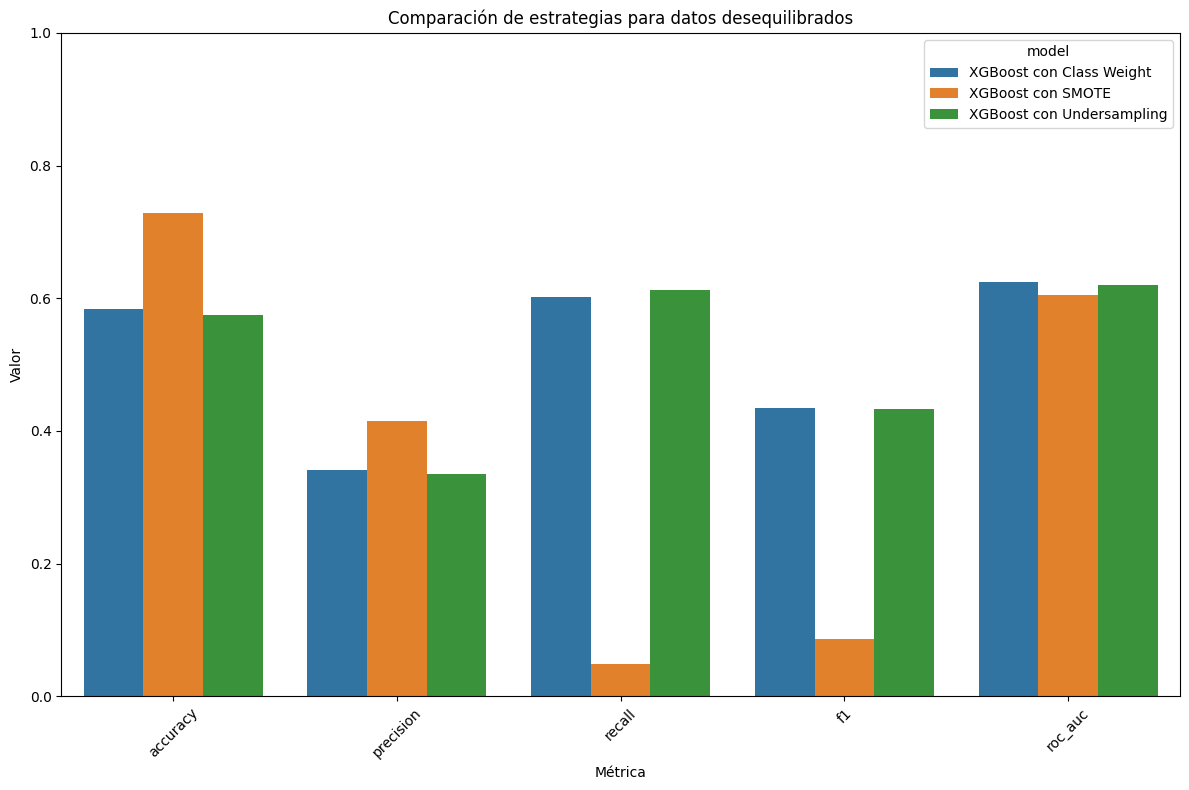


La mejor estrategia basada en F1-score es: XGBoost con Class Weight


In [41]:
# =================================================================
# Comparación de los tres enfoques
# =================================================================

# Crear un DataFrame para comparar los resultados
results_df = pd.DataFrame([results_weight, results_smote, results_under])

print("\n===== Comparación de estrategias =====")
print(results_df.set_index('model'))

# Visualizar la comparación de métricas
metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
plt.figure(figsize=(12, 8))

# Crear gráfico de barras para comparar métricas
results_df_melted = pd.melt(results_df, id_vars=['model'], value_vars=metrics, 
                           var_name='Métrica', value_name='Valor')

sns.barplot(x='Métrica', y='Valor', hue='model', data=results_df_melted)
plt.title('Comparación de estrategias para datos desequilibrados')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Encontrar la mejor estrategia basada en F1-score (puedes cambiar a otra métrica si prefieres)
best_model = results_df.loc[results_df['f1'].idxmax()]['model']
print(f"\nLa mejor estrategia basada en F1-score es: {best_model}")

# Modelo con optimización de parámetros

In [46]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Configuramos una semilla aleatoria para reproducibilidad
np.random.seed(42)

# Suponemos que ya tienes estos datos disponibles:
# train_df, y_train, val_df, y_valid

# Calculamos el ratio de desbalanceo para scale_pos_weight
# La fórmula básica es: número de muestras de clase negativa / número de muestras de clase positiva
neg_pos_ratio = np.sum(y_train == 0) / np.sum(y_train == 1)
print(f"Ratio de desbalanceo (neg/pos): {neg_pos_ratio:.4f}")

# Función para evaluar y visualizar resultados
def evaluate_and_display(model, X_train, y_train, X_val, y_val, model_name):
    # Predicciones
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Probabilidades para ROC-AUC
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_val_proba = model.predict_proba(X_val)[:, 1]
     
    # Métricas de validación
    val_metrics = {
        'accuracy': accuracy_score(y_val, y_val_pred),
        'precision': precision_score(y_val, y_val_pred),
        'recall': recall_score(y_val, y_val_pred),
        'f1': f1_score(y_val, y_val_pred),
        'roc_auc': roc_auc_score(y_val, y_val_proba)
    }
    
    # Matriz de confusión
    val_cm = confusion_matrix(y_val, y_val_pred)
    
    # Imprimir resultados
    print(f"\n===== {model_name} =====")    
    print("\nMétricas de validación:")
    for metric, value in val_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    # Mostrar matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Clase 0', 'Clase 1'],
                yticklabels=['Clase 0', 'Clase 1'])
    plt.xlabel('Predicción')
    plt.ylabel('Valor real')
    plt.title(f'Matriz de confusión - {model_name}')
    plt.tight_layout()
    plt.show()
    
    # Informe de clasificación
    print("\nInforme de clasificación (validación):")
    print(classification_report(y_val, y_val_pred))
    
    # Importancia de características
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': train_df.columns,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)

        print(feature_importance.head(50))
        
        '''
        # Mostrar top 15 características más importantes o todas si hay menos de 15
        n_features = min(15, len(feature_importance))
        plt.figure(figsize=(10, 8))
        sns.barplot(x='importance', y='feature', data=feature_importance.head(n_features))
        plt.title('Top 15 características más importantes')
        plt.tight_layout()
        plt.show()
        '''
    
    return val_metrics, y_val_proba







Ratio de desbalanceo (neg/pos): 2.8547



Entrenando modelo base con scale_pos_weight...

===== XGBoost Base con scale_pos_weight =====

Métricas de validación:
accuracy: 0.5839
precision: 0.3408
recall: 0.6014
f1: 0.4350
roc_auc: 0.6240


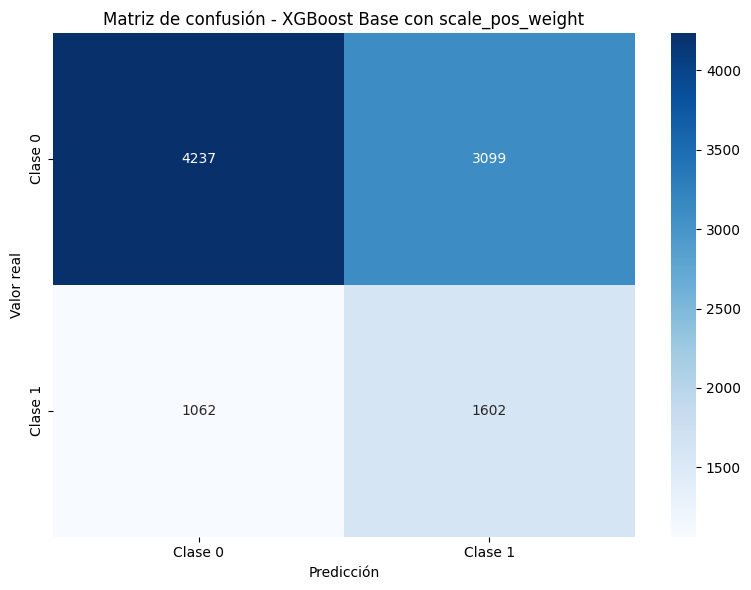


Informe de clasificación (validación):
              precision    recall  f1-score   support

           0       0.80      0.58      0.67      7336
           1       0.34      0.60      0.44      2664

    accuracy                           0.58     10000
   macro avg       0.57      0.59      0.55     10000
weighted avg       0.68      0.58      0.61     10000

                         feature  importance
231          OCCUPATION_TYPE_1.0    0.044256
85            MARITAL_STATUS_1.0    0.025136
5         FLAG_RESIDENCIAL_PHONE    0.020675
81              PAYMENT_DAY_25.0    0.020588
88            MARITAL_STATUS_4.0    0.018450
77               PAYMENT_DAY_5.0    0.012870
78              PAYMENT_DAY_10.0    0.012040
287                     AGE_63.0    0.011049
242                     AGE_18.0    0.010676
18       FLAG_PROFESSIONAL_PHONE    0.010371
50          RESIDENCIAL_STATE_AL    0.010103
86            MARITAL_STATUS_2.0    0.009276
254                     AGE_30.0    0.008892
282

In [47]:

# Modelo base con scale_pos_weight básico
print("\nEntrenando modelo base con scale_pos_weight...")
base_model = xgb.XGBClassifier(
    scale_pos_weight=neg_pos_ratio,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)
base_model.fit(train_df, y_train)

# Evaluamos el modelo base
base_metrics, base_proba = evaluate_and_display(
    base_model, train_df, y_train, val_df, y_valid, 
    "XGBoost Base con scale_pos_weight"
)


Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Tiempo total de búsqueda: 2.58 minutos

Mejores hiperparámetros encontrados:
subsample: 0.7
scale_pos_weight: 4.282017924255565
reg_lambda: 10
reg_alpha: 0.1
n_estimators: 200
min_child_weight: 5
max_depth: 4
learning_rate: 0.2
gamma: 0.3
colsample_bytree: 0.8

===== XGBoost Optimizado con scale_pos_weight =====

Métricas de validación:
accuracy: 0.4879
precision: 0.3188
recall: 0.8112
f1: 0.4577
roc_auc: 0.6387


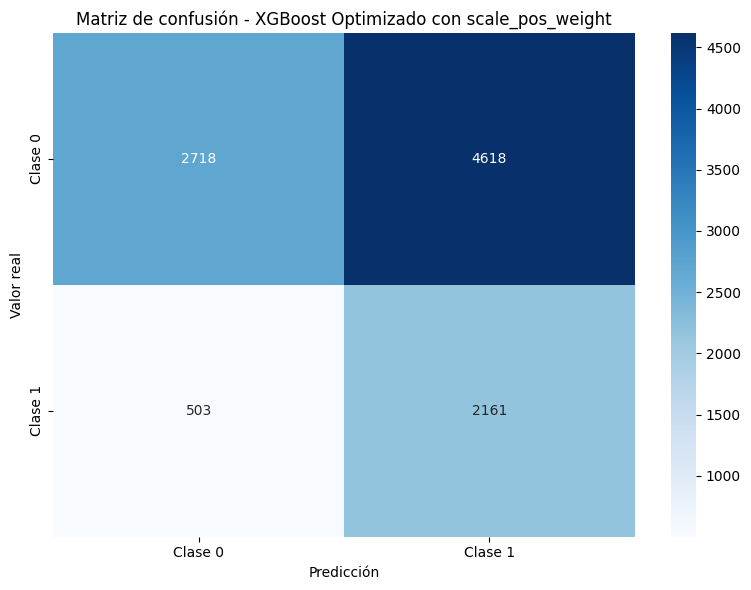


Informe de clasificación (validación):
              precision    recall  f1-score   support

           0       0.84      0.37      0.51      7336
           1       0.32      0.81      0.46      2664

    accuracy                           0.49     10000
   macro avg       0.58      0.59      0.49     10000
weighted avg       0.70      0.49      0.50     10000

                        feature  importance
81             PAYMENT_DAY_25.0    0.012874
5        FLAG_RESIDENCIAL_PHONE    0.011499
231         OCCUPATION_TYPE_1.0    0.011494
85           MARITAL_STATUS_1.0    0.011475
88           MARITAL_STATUS_4.0    0.009582
287                    AGE_63.0    0.009168
203  QUANT_BANKING_ACCOUNTS_1.0    0.008932
242                    AGE_18.0    0.007973
283                    AGE_59.0    0.007620
254                    AGE_30.0    0.007548
244                    AGE_20.0    0.007359
291                    AGE_67.0    0.007330
32            STATE_OF_BIRTH_MG    0.007130
255              

In [48]:
# Definimos el espacio de hiperparámetros para la búsqueda
# Aquí incluimos varios valores de scale_pos_weight alrededor del ratio calculado
# para encontrar el valor óptimo
param_space = {
    'scale_pos_weight': [1, neg_pos_ratio/2, neg_pos_ratio, neg_pos_ratio*1.5, neg_pos_ratio*2],
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.5],
    'min_child_weight': [1, 3, 5, 7],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [0, 0.1, 1, 10]
}

print("\nIniciando búsqueda de hiperparámetros...")
start_time = time.time()

# Definimos la validación cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Definimos la búsqueda aleatoria
search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic', random_state=42),
    param_distributions=param_space,
    n_iter=50,  # Número de combinaciones a probar
    scoring='f1',  # Optimizamos para F1 score
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1  # Usar todos los núcleos disponibles
)

# Ejecutamos la búsqueda
search.fit(train_df, y_train)

# Tiempo total de búsqueda
end_time = time.time()
print(f"\nTiempo total de búsqueda: {(end_time - start_time)/60:.2f} minutos")

# Mostramos los mejores parámetros encontrados
print("\nMejores hiperparámetros encontrados:")
for param, value in search.best_params_.items():
    print(f"{param}: {value}")

# Evaluamos el modelo optimizado
best_model = search.best_estimator_
tuned_metrics, tuned_proba = evaluate_and_display(
    best_model, train_df, y_train, val_df, y_valid, 
    "XGBoost Optimizado con scale_pos_weight"
)


===== Comparación de modelos =====
     Métrica  Modelo Base  Modelo Optimizado  Mejora (%)
0   accuracy     0.583900           0.487900  -16.441171
1  precision     0.340779           0.318779   -6.455798
2     recall     0.601351           0.811186   34.893883
3         f1     0.435031           0.457694    5.209515
4    roc_auc     0.623951           0.638651    2.355866

Umbral óptimo para F1-score: 0.550


/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


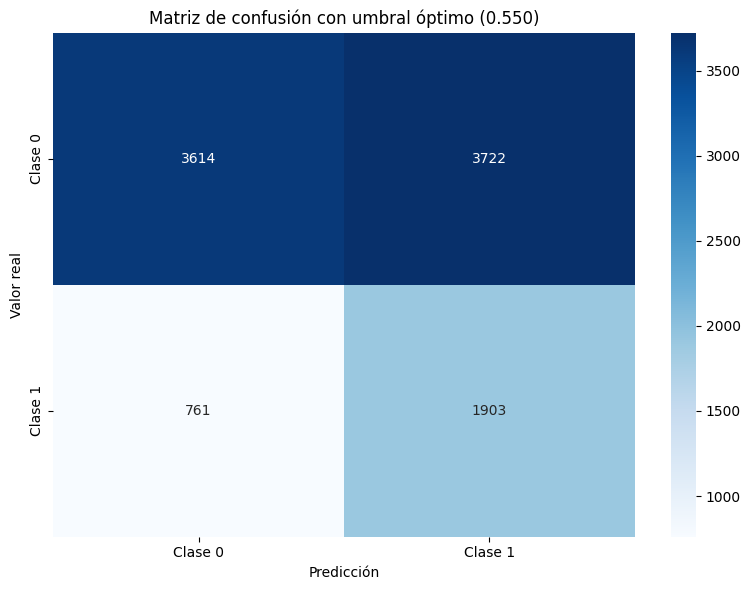


===== RESUMEN FINAL =====
Ratio de desbalanceo original: 2.8547
scale_pos_weight óptimo: 4.2820
Otros hiperparámetros óptimos: 
  - subsample: 0.7
  - reg_lambda: 10
  - reg_alpha: 0.1
  - n_estimators: 200
  - min_child_weight: 5
  - max_depth: 4
  - learning_rate: 0.2
  - gamma: 0.3
  - colsample_bytree: 0.8

Mejor umbral de clasificación: 0.550

Métricas finales (con umbral óptimo):
Accuracy: 0.5517
Precision: 0.3383
Recall: 0.7143
F1-score: 0.4592
ROC-AUC: 0.6387

Mejora porcentual respecto al modelo base:
accuracy: -5.51%
precision: -0.72%
recall: 18.79%
f1: 5.55%
roc_auc: 2.36%
                        feature  importance
81             PAYMENT_DAY_25.0    0.012874
5        FLAG_RESIDENCIAL_PHONE    0.011499
231         OCCUPATION_TYPE_1.0    0.011494
85           MARITAL_STATUS_1.0    0.011475
88           MARITAL_STATUS_4.0    0.009582
287                    AGE_63.0    0.009168
203  QUANT_BANKING_ACCOUNTS_1.0    0.008932
242                    AGE_18.0    0.007973
283         

In [49]:
# Comparamos métricas entre modelo base y optimizado
metrics_comparison = pd.DataFrame({
    'Métrica': list(base_metrics.keys()),
    'Modelo Base': list(base_metrics.values()),
    'Modelo Optimizado': list(tuned_metrics.values()),
    'Mejora (%)': [(tuned_metrics[k] - base_metrics[k])/base_metrics[k]*100 for k in base_metrics.keys()]
})

print("\n===== Comparación de modelos =====")
print(metrics_comparison)

# Exploramos el efecto del umbral de decisión
thresholds_to_try = np.arange(0.1, 1.0, 0.05)
threshold_results = []

for threshold in thresholds_to_try:
    # Aplicamos el umbral a las probabilidades del modelo optimizado
    y_val_pred_threshold = (tuned_proba >= threshold).astype(int)
    
    # Calculamos métricas con este umbral
    accuracy = accuracy_score(y_valid, y_val_pred_threshold)
    precision = precision_score(y_valid, y_val_pred_threshold)
    recall = recall_score(y_valid, y_val_pred_threshold)
    f1 = f1_score(y_valid, y_val_pred_threshold)
    
    threshold_results.append({
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    })

# Convertimos a DataFrame para facilitar la visualización
threshold_df = pd.DataFrame(threshold_results)

# Identificamos el umbral óptimo para F1-score
best_f1_idx = threshold_df['f1'].idxmax()
best_threshold = threshold_df.loc[best_f1_idx, 'threshold']
print(f"\nUmbral óptimo para F1-score: {best_threshold:.3f}")

# Matriz de confusión con el umbral óptimo
y_val_pred_optimal = (tuned_proba >= best_threshold).astype(int)
cm_optimal = confusion_matrix(y_valid, y_val_pred_optimal)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Clase 0', 'Clase 1'],
            yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title(f'Matriz de confusión con umbral óptimo ({best_threshold:.3f})')
plt.tight_layout()
plt.show()

# Guardar el modelo optimizado
#best_model.save_model('xgboost_best_model_scale_pos_weight.json')
#print("\nEl modelo optimizado ha sido guardado como 'xgboost_best_model_scale_pos_weight.json'")

# Resumen final
print("\n===== RESUMEN FINAL =====")
print(f"Ratio de desbalanceo original: {neg_pos_ratio:.4f}")
print(f"scale_pos_weight óptimo: {search.best_params_['scale_pos_weight']:.4f}")
print(f"Otros hiperparámetros óptimos: ")
for param, value in search.best_params_.items():
    if param != 'scale_pos_weight':
        print(f"  - {param}: {value}")

print(f"\nMejor umbral de clasificación: {best_threshold:.3f}")
print("\nMétricas finales (con umbral óptimo):")
print(f"Accuracy: {accuracy_score(y_valid, y_val_pred_optimal):.4f}")
print(f"Precision: {precision_score(y_valid, y_val_pred_optimal):.4f}")
print(f"Recall: {recall_score(y_valid, y_val_pred_optimal):.4f}")
print(f"F1-score: {f1_score(y_valid, y_val_pred_optimal):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_valid, tuned_proba):.4f}")

# Comparativa final de mejora
print("\nMejora porcentual respecto al modelo base:")
optimal_metrics = {
    'accuracy': accuracy_score(y_valid, y_val_pred_optimal),
    'precision': precision_score(y_valid, y_val_pred_optimal),
    'recall': recall_score(y_valid, y_val_pred_optimal),
    'f1': f1_score(y_valid, y_val_pred_optimal),
    'roc_auc': roc_auc_score(y_valid, tuned_proba)
}

for metric in optimal_metrics:
    improvement = (optimal_metrics[metric] - base_metrics[metric])/base_metrics[metric]*100
    print(f"{metric}: {improvement:.2f}%")


if hasattr(best_model, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': train_df.columns,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)

print(feature_importance.head(40))

In [61]:
print(feature_importance[['feature']].head(50).to_string(index=False))

                   feature
          PAYMENT_DAY_25.0
    FLAG_RESIDENCIAL_PHONE
       OCCUPATION_TYPE_1.0
        MARITAL_STATUS_1.0
        MARITAL_STATUS_4.0
                  AGE_63.0
QUANT_BANKING_ACCOUNTS_1.0
                  AGE_18.0
                  AGE_59.0
                  AGE_30.0
                  AGE_20.0
                  AGE_67.0
         STATE_OF_BIRTH_MG
                  AGE_31.0
      RESIDENCIAL_STATE_RS
           FLAG_MASTERCARD
                  AGE_55.0
           PAYMENT_DAY_5.0
                  AGE_70.0
        RESIDENCE_TYPE_2.0
                  AGE_56.0
      QUANT_DEPENDANTS_3.0
                  AGE_53.0
                  AGE_49.0
          PAYMENT_DAY_10.0
                  AGE_19.0
                  AGE_24.0
                  AGE_57.0
                  AGE_62.0
                  AGE_66.0
                  AGE_69.0
                  AGE_51.0
  MONTHS_IN_RESIDENCE_50.0
      QUANT_DEPENDANTS_4.0
                  AGE_22.0
                       SEX
 

# Modelo con features reducido

In [50]:
# Reducing features once more

#Reducing dataframe features

#Features encoded with frequency or ordinal 
selected_features = ["FLAG_MASTERCARD", "FLAG_RESIDENCIAL_PHONE", "RESIDENCIAL_PHONE_AREA_CODE", "SEX"]

#Features encoded with one hot encoder
defined_features = ["AGE", "MONTHS_IN_RESIDENCE", "PAYMENT_DAY", "PRODUCT", "PROFESSION_CODE", "QUANT_BANKING_ACCOUNTS", "QUANT_DEPENDANTS", "QUANT_SPECIAL_BANKING_ACCOUNTS", "RESIDENCE_TYPE", "RESIDENCIAL_STATE", "STATE_OF_BIRTH"]

selected_columns = [col for col in train_df.columns if any(feature in col for feature in defined_features)]

features_to_keep = selected_features + selected_columns

print(len(features_to_keep))

reduced_train_df = train_df[features_to_keep].copy()
reduced_validation_df = val_df[features_to_keep].copy()

#print(reduced_train_df[selected_columns].head().to_string())

289



Métricas de validación:
Accuracy: 0.4531
Precision: 0.3080
Recall: 0.8446
F1 Score: 0.4514
ROC-AUC: 0.6219

Matriz de confusión (validación):
[[2281 5055]
 [ 414 2250]]


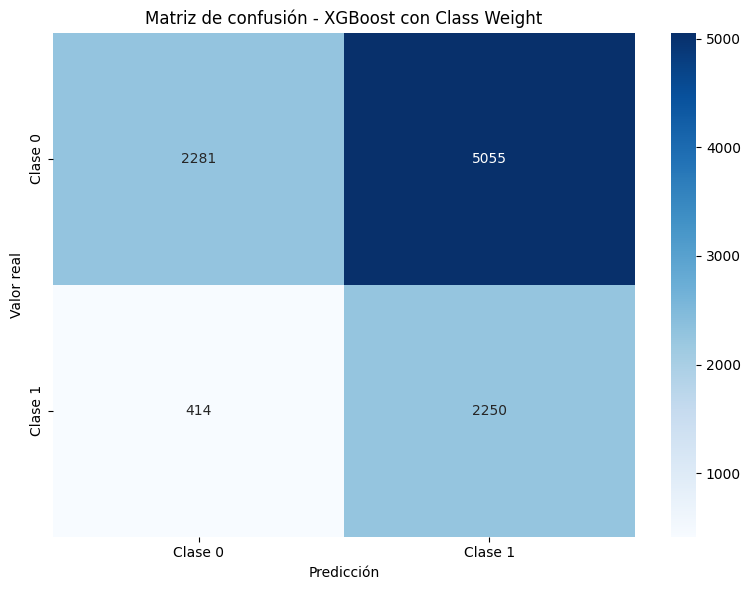

In [ ]:

# =================================================================
# XGBoost scale_pos_weight (Class Weight)
# =================================================================

best_model.fit(reduced_train_df, y_train)

# Evaluar el modelo con class weight
results_weight = evaluate_model(best_model, reduced_train_df, y_train, reduced_validation_df, y_valid, "XGBoost con Class Weight")

In [ ]:
# Reducing features once more

#Reducing dataframe features

#Features encoded with frequency or ordinal 
selected_features = ["FLAG_MASTERCARD", "FLAG_RESIDENCIAL_PHONE", "FLAG_PROFESSIONAL_PHONE", "SEX"]

#Features encoded with one hot encoder
defined_features = ["AGE", "MONTHS_IN_RESIDENCE", "PAYMENT_DAY",  "PROFESSION_CODE", "QUANT_BANKING_ACCOUNTS", "QUANT_DEPENDANTS", "RESIDENCE_TYPE",  "RESIDENCIAL_STATE", "STATE_OF_BIRTH", "OCCUPATION_TYPE", "MARITAL_STATUS"]

selected_columns = [col for col in train_df.columns if any(feature in col for feature in defined_features)]

features_to_keep = selected_features + selected_columns

print(len(features_to_keep))

train = train_df[features_to_keep].copy()
validation = val_df[features_to_keep].copy()

#print(reduced_train_df[selected_columns].head().to_string())

294



Métricas de validación:
Accuracy: 0.4469
Precision: 0.3044
Recall: 0.8371
F1 Score: 0.4464
ROC-AUC: 0.6211

Matriz de confusión (validación):
[[2239 5097]
 [ 434 2230]]


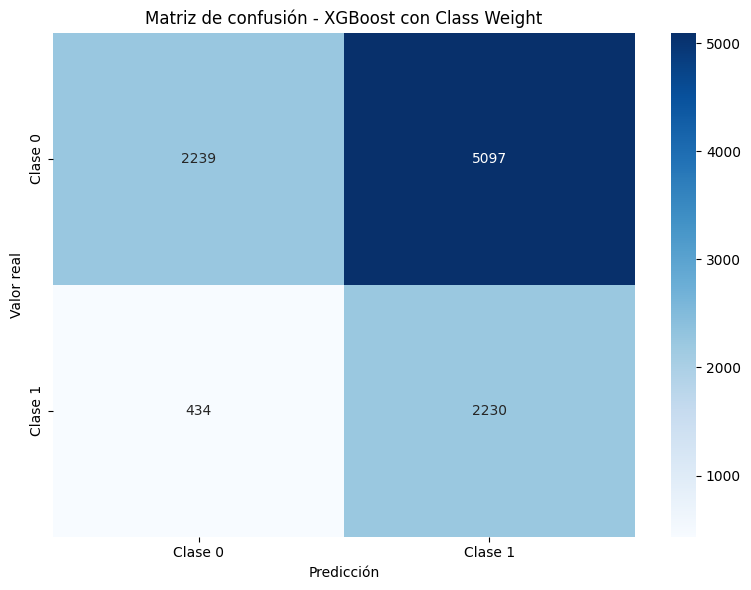

In [ ]:

# =================================================================
# Training the model with 15 features only
# =================================================================

best_model.fit(train, y_train)

# Evaluar el modelo con class weight
results_weight = evaluate_model(best_model, train, y_train, validation, y_valid, "XGBoost con Class Weight")

# Entrenamiento anterior sin considerar casos

## XGBoost with default parameters

In [52]:
#Training a XGBoost model with default params

# Convert data to DMatrix format
dtrain = xgb.DMatrix(train_df, label=y_train)
dvalid = xgb.DMatrix(val_df, label=y_valid)

# Define parameters
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "eta": 0.1,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1,
    "alpha": 0
}

# Train model
evals = [(dtrain, "train"), (dvalid, "valid")]
model = xgb.train(params, dtrain, num_boost_round=100, evals=evals, early_stopping_rounds=10)

# Predictions
y_pred_proba = model.predict(dvalid)
y_pred = (y_pred_proba > 0.5).astype(int)

# Performance Metrics
conf_matrix = confusion_matrix(y_valid, y_pred)
print("Confusion Matrix:\n", conf_matrix)
print("\nAccuracy:", accuracy_score(y_valid, y_pred))
print("\nClassification Report:\n", classification_report(y_valid, y_pred))

[0]	train-logloss:0.57025	valid-logloss:0.57770
[1]	train-logloss:0.56766	valid-logloss:0.57599
[2]	train-logloss:0.56556	valid-logloss:0.57466
[3]	train-logloss:0.56358	valid-logloss:0.57344
[4]	train-logloss:0.56166	valid-logloss:0.57255
[5]	train-logloss:0.56003	valid-logloss:0.57173
[6]	train-logloss:0.55860	valid-logloss:0.57105
[7]	train-logloss:0.55714	valid-logloss:0.57029
[8]	train-logloss:0.55590	valid-logloss:0.56975
[9]	train-logloss:0.55449	valid-logloss:0.56905
[10]	train-logloss:0.55330	valid-logloss:0.56846
[11]	train-logloss:0.55215	valid-logloss:0.56811
[12]	train-logloss:0.55114	valid-logloss:0.56763
[13]	train-logloss:0.55012	valid-logloss:0.56718
[14]	train-logloss:0.54903	valid-logloss:0.56652
[15]	train-logloss:0.54824	valid-logloss:0.56646
[16]	train-logloss:0.54747	valid-logloss:0.56601
[17]	train-logloss:0.54658	valid-logloss:0.56584
[18]	train-logloss:0.54572	valid-logloss:0.56553
[19]	train-logloss:0.54482	valid-logloss:0.56558
[20]	train-logloss:0.54414	val

In [53]:
# Hyperparameter tuning

param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [50, 100, 200],
    "subsample": [0.6, 0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]  
}

xgb_clf = xgb.XGBClassifier(objective="binary:logistic", eval_metric="logloss")

grid_search = GridSearchCV(xgb_clf, param_grid, scoring="accuracy", cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=-1, verbose=1)
grid_search.fit(train_df, y_train)

print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x114814d50>>
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/xgboost/core.py", line 582, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument

KeyboardInterrupt: 


KeyboardInterrupt: 

In [40]:
# Define parameters based on parameter optimization
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "eta": 0.05,
    "max_depth": 7,
    "subsample": 0.8,
    "colsample_bytree": 1.0,
    "lambda": 1,
    "alpha": 0
}

# Train model
evals = [(dtrain, "train"), (dvalid, "valid")]
model = xgb.train(params, dtrain, num_boost_round=100, evals=evals, early_stopping_rounds=10)

# Predictions
y_pred_proba = model.predict(dvalid)
y_pred = (y_pred_proba > 0.5).astype(int)

# Performance Metrics
conf_matrix = confusion_matrix(y_valid, y_pred)
print("Confusion Matrix:\n", conf_matrix)
print("\nAccuracy:", accuracy_score(y_valid, y_pred))
print("\nClassification Report:\n", classification_report(y_valid, y_pred))

[0]	train-logloss:0.57128	valid-logloss:0.57874
[1]	train-logloss:0.56951	valid-logloss:0.57767
[2]	train-logloss:0.56781	valid-logloss:0.57654
[3]	train-logloss:0.56616	valid-logloss:0.57554
[4]	train-logloss:0.56462	valid-logloss:0.57475
[5]	train-logloss:0.56319	valid-logloss:0.57397
[6]	train-logloss:0.56189	valid-logloss:0.57333
[7]	train-logloss:0.56062	valid-logloss:0.57272
[8]	train-logloss:0.55946	valid-logloss:0.57226
[9]	train-logloss:0.55828	valid-logloss:0.57167
[10]	train-logloss:0.55720	valid-logloss:0.57114
[11]	train-logloss:0.55601	valid-logloss:0.57070
[12]	train-logloss:0.55507	valid-logloss:0.57030
[13]	train-logloss:0.55406	valid-logloss:0.56993
[14]	train-logloss:0.55317	valid-logloss:0.56958
[15]	train-logloss:0.55226	valid-logloss:0.56925
[16]	train-logloss:0.55130	valid-logloss:0.56887
[17]	train-logloss:0.55024	valid-logloss:0.56852
[18]	train-logloss:0.54933	valid-logloss:0.56819
[19]	train-logloss:0.54854	valid-logloss:0.56793
[20]	train-logloss:0.54765	val

In [41]:
# Get feature importance by gain
importance = model.get_score(importance_type="gain")
importance_df = pd.DataFrame(importance.items(), columns=["Feature", "Gain"]).sort_values(by="Gain", ascending=False)

print(importance_df.head(20))



                    Feature       Gain
135     OCCUPATION_TYPE_1.0  24.007029
5    FLAG_RESIDENCIAL_PHONE  19.475811
70         PAYMENT_DAY_25.0  16.645630
72       MARITAL_STATUS_1.0  15.721720
187                AGE_63.0  11.813228
142                AGE_18.0  11.207093
144                AGE_20.0  10.865468
154                AGE_30.0  10.059038
127     PROFESSION_CODE_8.0   9.959561
145                AGE_21.0   9.810191
195                AGE_71.0   9.788873
181                AGE_57.0   9.709737
198                AGE_78.0   9.684025
190                AGE_66.0   9.646227
90       RESIDENCE_TYPE_3.0   9.358445
192                AGE_68.0   9.228590
77       MARITAL_STATUS_6.0   9.227916
183                AGE_59.0   9.175991
182                AGE_58.0   9.065054
194                AGE_70.0   9.003184


## Training XGBoost with imbalanced data strategy

In [42]:
# XGBoost model computing class weights for handling class imbalance
# First a model training using default param values
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42)

# Fit the model
xgb_model.fit(train_df, y_train)

# Evaluate initial performance on validation set
y_pred = xgb_model.predict(val_df)
y_pred_prob = xgb_model.predict_proba(val_df)[:, 1]

# Metrics
print("Classification Report:")
print(classification_report(y_valid, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_valid, y_pred_prob))
print("Confusion Matrix:")
print(confusion_matrix(y_valid, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.96      0.84      7336
           1       0.43      0.08      0.13      2664

    accuracy                           0.73     10000
   macro avg       0.58      0.52      0.48     10000
weighted avg       0.66      0.73      0.65     10000

ROC-AUC Score: 0.6301169455988159
Confusion Matrix:
[[7062  274]
 [2461  203]]


In [43]:
# Defining hyperparameters and  balancing dataset.

# Compute class weights to adjust scale_pos_weight
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
scale_pos_weight = class_weights[1] / class_weights[0]  # Calculate scale_pos_weight

# Set up XGBoost model with hyperparameter tuning
params = {
    'scale_pos_weight': [scale_pos_weight],  # Use the computed scale_pos_weight
    'max_depth': [3, 5, 7],  # Example of tuning max_depth
    'learning_rate': [0.01, 0.05, 0.1],  # Learning rate
    'n_estimators': [100, 200],  # Number of estimators
    'subsample': [0.8, 1.0],  # Fraction of samples used for each tree
    'colsample_bytree': [0.8, 1.0]  # Fraction of features used for each tree
}

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(eval_metric='mlogloss', random_state=42),
    param_grid=params,
    scoring=make_scorer(roc_auc_score),  # Scoring by ROC AUC
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=2,
    n_jobs=-1
)

In [37]:
# Fit the model with cross-validation and grid search
grid_search.fit(train_df, y_train)

# Best parameters and best score from the grid search
print("Best parameters:", grid_search.best_params_)
print("Best ROC-AUC score:", grid_search.best_score_)

# Step 4: Evaluate best model on validation set
best_model = grid_search.best_estimator_

# Predict on the validation set
y_pred_best = best_model.predict(val_df)
y_pred_prob_best = best_model.predict_proba(val_df)[:, 1]

# Metrics
print("Classification Report for Best Model:")
print(classification_report(y_valid, y_pred_best))
print("ROC-AUC Score for Best Model:", roc_auc_score(y_valid, y_pred_prob_best))
print("Confusion Matrix for Best Model:")
print(confusion_matrix(y_valid, y_pred_best))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=2.8546786161703768, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=2.8546786161703768, subsample=0.8; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=2.8546786161703768, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=2.8546786161703768, subsample=1.0; total time=   2.4s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=2.8546786161703768, subsample=0.8; total time=   2.5s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, scale_pos_weight=2.8546786161703768, subsample=1.0; total time=   2.4s
[CV] END colsample_b

In [48]:
# Feature Importance using Gain
importance = best_model.get_booster().get_score(importance_type="gain")

# Convert to DataFrame for better visualization
importance_df = pd.DataFrame(importance.items(), columns=["Feature", "Gain"])
importance_df = importance_df.sort_values(by="Gain", ascending=False)

# Print feature importance
print("\nFeature Importance (Gain):")
print(importance_df.head(40))



Feature Importance (Gain):
                         Feature       Gain
122          OCCUPATION_TYPE_1.0  87.293053
64            MARITAL_STATUS_1.0  71.281769
63              PAYMENT_DAY_25.0  63.121243
5         FLAG_RESIDENCIAL_PHONE  50.562473
60              PAYMENT_DAY_10.0  42.450478
67            MARITAL_STATUS_4.0  36.159863
167                     AGE_63.0  32.977535
80            RESIDENCE_TYPE_1.0  28.239454
15       FLAG_PROFESSIONAL_PHONE  25.816042
142                     AGE_31.0  25.569647
65            MARITAL_STATUS_2.0  24.818583
79               NACIONALITY_1.0  24.803543
129                     AGE_18.0  24.414759
13                    QUANT_CARS  24.050468
155                     AGE_48.0  23.812122
59               PAYMENT_DAY_5.0  23.791893
1                            SEX  23.218260
110   QUANT_BANKING_ACCOUNTS_1.0  23.143536
158                     AGE_53.0  22.792255
159                     AGE_55.0  22.432432
49          RESIDENCIAL_STATE_PB  22.306227
62  